In [1]:
import numpy as np
import pandas as pd
import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import roc_auc_score
from skimage.feature import canny
import cv2
import os
import seaborn as sns

%config Completer.use_jedi = False

In [2]:
train_dir = 'train_mod2'
test_dir = 'test_mod2'
a = pd.read_csv('annotations.csv', index_col=False)
a.filepath = a.filepath.str.replace('train\\ER', train_dir, regex=False).str.replace('train\\NR', train_dir, regex=False)
a

,filepath,type,energy
0,train_mod2\-0.003018522635102272__CYGNO_60_40_...,ER,30
1,train_mod2\-0.0031084376387298107__CYGNO_60_40...,ER,3
2,train_mod2\-0.003241758095100522__CYGNO_60_40_...,ER,3
3,train_mod2\-0.0032767392694950104__CYGNO_60_40...,ER,10
4,train_mod2\-0.004240238573402166__CYGNO_60_40_...,ER,3
...,...,...,...
13399,train_mod2\3.1387999057769775__CYGNO_60_40_He_...,He,1
13400,train_mod2\3.140399932861328__CYGNO_60_40_He_N...,He,20
13401,train_mod2\3.1407999992370605__CYGNO_60_40_He_...,He,20
13402,train_mod2\3.1412999629974365__CYGNO_60_40_He_...,He,6


In [3]:
kernel = np.ones(shape=(3,3))
nz, avg, std = [], [], []
nzcs = {key: [] for key in (0, 1, 2, 3)}
quants = {key: [] for key in np.arange(0.1, 1, 0.1)}
for fp in tqdm.tqdm(a.filepath):
    img = cv2.imread(fp, 0)
    nz.append(np.count_nonzero(img))
    avg.append(img[(img>0)].mean())
    std.append(img[(img>0)].std())
    for sigma in nzcs:
        nzcs[sigma].append(np.count_nonzero(canny(img, sigma=sigma)))
    for q in quants:
        quants[q].append(np.quantile(img[(img>0)], q))
train_ds = pd.DataFrame({'nz': nz, 'avg': avg, 'std': std})
for i, q in enumerate(quants):
    train_ds[f'q{i}'] = quants[q]
for i, s in enumerate(nzcs):
    train_ds[f'nzc{i}'] = nzcs[s]

100%|████████████████████████████████████████████████████████████████████████████| 13404/13404 [04:39<00:00, 48.00it/s]


<AxesSubplot:xlabel='nz', ylabel='Count'>

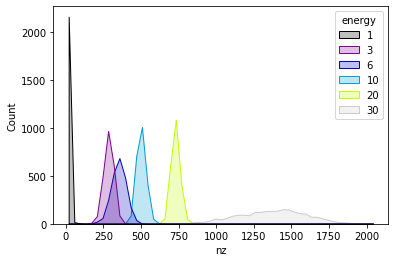

In [49]:
sns.histplot(x=train_ds['nz'], hue=a.energy, element='poly', palette='nipy_spectral')

In [4]:
def fit_cbc(X, y):
    model = CatBoostClassifier(random_seed=42, verbose=0)
    model.fit(X, y)
    return model

In [6]:
cols = train_ds.columns
model_energy = fit_cbc(train_ds[cols], a['energy'].astype(str))
model_type = fit_cbc(train_ds[cols], a['type'].astype(str))

In [10]:
filenames = tuple(os.walk(test_dir))[0][2]
nz, nzc, avg, std = [], [], [], []
nzcs = {key: [] for key in (0, 1, 2, 3)}
quants = {key: [] for key in np.arange(0.1, 1, 0.1)}
for fn in tqdm.tqdm(filenames):
    img = cv2.imread(f'{test_dir}\\{fn}', 0)
    nz.append(np.count_nonzero(img))
    for sigma in nzcs:
        nzcs[sigma].append(np.count_nonzero(canny(img, sigma=sigma)))
    avg.append(img[(img>0)].mean())
    std.append(img[(img>0)].std())
    for q in quants:
        quants[q].append(np.quantile(img[(img>0)], q))
test = pd.DataFrame({'id': [x.split('.')[0] for x in filenames], 'nz': nz, 'avg': avg, 'std': std})
for i, s in enumerate(nzcs):
    test[f'nzc{i}'] = nzcs[s]
for i, q in enumerate(quants):
    test[f'q{i}'] = quants[q]

100%|████████████████████████████████████████████████████████████████████████████| 16560/16560 [06:16<00:00, 44.03it/s]


In [11]:
test_ds = test[cols]
test_type = model_type.predict(test_ds)
test_energy = model_energy.predict(test_ds)
test['regression_predictions'] = test_energy.flatten()
test['classification_predictions'] = [1 if x == 'ER' else 0 for x in test_type.flatten()]
test

,id,nz,avg,std,nzc0,nzc1,nzc2,nzc3,q0,q1,q2,q3,q4,q5,q6,q7,q8,regression_predictions,classification_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,409,110.833741,7.627433,432,318,98,58,104.0,105.0,106.0,107.0,108.0,110.0,113.0,116.0,122.2,3,1
1,0005564c011259402dcb6e3beb6e64d285124fa0,958,115.886221,12.867017,902,662,171,114,104.0,105.0,107.0,109.0,111.0,115.0,119.0,125.0,133.0,30,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,819,121.792430,19.940532,697,520,158,99,104.8,106.0,107.0,110.0,113.0,118.0,126.0,137.4,154.0,30,1
3,000804a189f630cd980ff1543c0ef99d48cd6b34,1,130.000000,0.000000,5,5,0,0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,1,0
4,000eb12def5371089743dcfe401a8e399f5883fc,833,121.156062,19.852751,694,551,178,97,104.0,105.0,107.0,109.0,112.0,118.0,126.0,137.0,153.0,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16555,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580,497,110.144869,5.848450,471,378,168,75,104.0,105.0,106.0,107.0,108.0,110.0,112.0,115.0,119.0,10,1
16556,ffed718417c6923844d33e70491c54396e3ec1ed,3,116.333333,13.199327,10,8,0,0,107.0,107.0,107.0,107.0,107.0,112.6,118.2,123.8,129.4,1,0
16557,ffedc12ec5c142dae2086408b778cf0db2ff944e,311,108.524116,4.633018,345,318,87,52,104.0,105.0,105.0,106.0,107.0,108.0,110.0,112.0,116.0,3,1
16558,fff7b36d8ef90c90d9598620b87dabc0360f501c,2,132.000000,0.000000,16,16,0,0,132.0,132.0,132.0,132.0,132.0,132.0,132.0,132.0,132.0,1,0


In [12]:
len(test['id'])

16560

In [13]:
test[['id', 'classification_predictions', 'regression_predictions']].to_csv('results\\simple_2_v2_final.csv', index=False)

In [7]:
model_energy.save_model('saved_models\\cbc_energy2')
model_type.save_model('saved_models\\cbc_type2')